# Exploration

Before training a model, we’ll spend some time exploring the dataset we’ll use: the *Oxford Flowers102* image set. Rather than training a Convolutional Neural Network (CNN) from scratch, we will use transfer learning with a pretrained model (ResNet18). This means the lower layers of the network already understand general visual features (edges, textures, shapes), and we only need to fine-tune the final layers for our specific task: predicting coarse flower color classes.

In [1]:
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import torch

# Because ResNet18 was trained on 224 pixel x 224 pixel images, we transform the images from 
# the Flower102 datasets to be the same size in preparation for creating image labels.
label_tf = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# We gather up a sample of the Flowers102 dataset to explore, using the pre-defined 'train' split.
train_ds = Flowers102(root="../data", split="train", download=True, transform=label_tf)
print("Number of training images: ", len(train_ds))

Number of training images:  1020


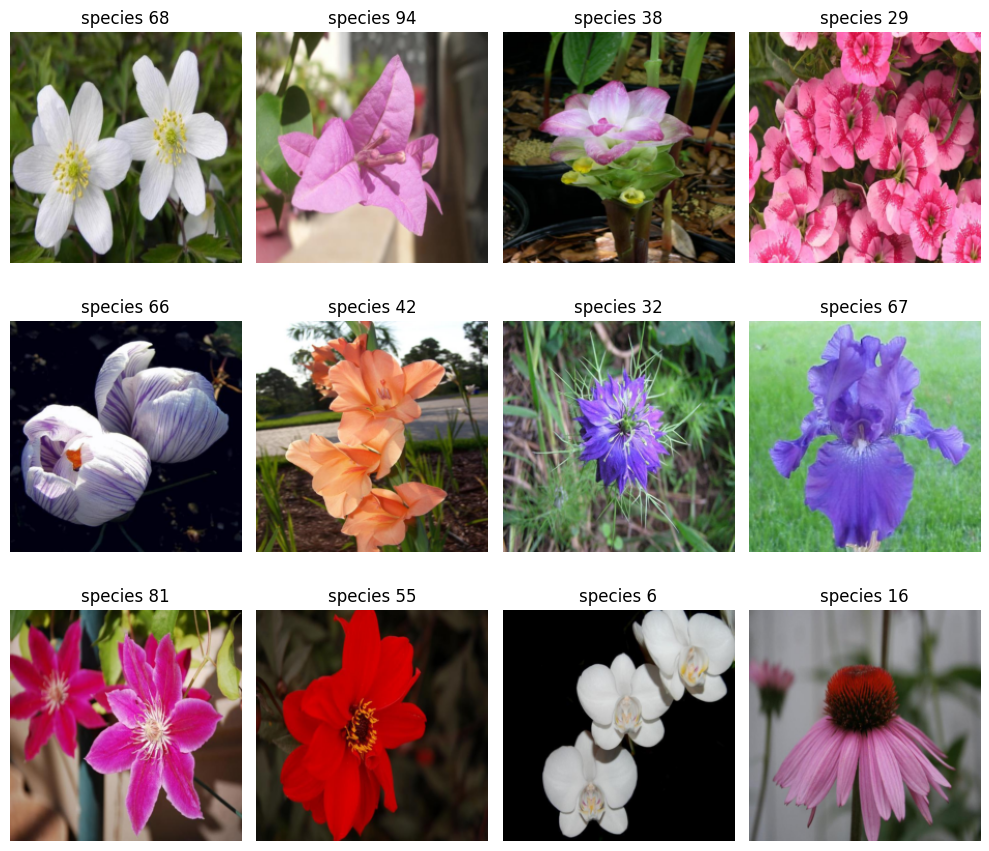

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Each FLowers102 sample returns a transformed image (as we defined above) and a label from 0-101
# representing one of the 102 flower species in the dataset.
def show_batch(ds, n=12):
    rows = n // 4
    fig, axes = plt.subplots(rows, 4, figsize=(10, 3 * rows))
    for ax in axes.ravel():
        i = np.random.randint(len(ds))
        img, label = ds[i]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"species {label}")
        ax.axis("off")
    plt.tight_layout()

show_batch(train_ds)

# Short-Cut Labeling

The Flowers102 dataset contains 8,189 images, which is too many to label by hand for a small demonstration project. Instead, we’ll generate coarse color labels automatically using simple heuristics. 

This is intentionally a “quick and dirty” labeling approach: it won’t be perfect, but it is good enough to train a model that can recognize broad color categories. Later, once the classifier is trained, it will learn a far more flexible representation of petal color than this shortcut method.

## `hue_collector`

If you skim through the Flowers102 images, you’ll notice that the flower is typically centered in the frame. 
To estimate petal color, we will:

1. Extract only the center region of each image (where the flower usually is).
2. Sample every 6th pixel to reduce data size while keeping the sampling reproducible.
3. Convert those sampled pixels into hue values later, which we will use to assign color labels.

This gives us a lightweight way to approximate the dominant color of the flower without any manual annotation.

In [3]:
def hue_collector(img_tensor, center_frac=0.5, stride=6):
    """
    Extract RGB pixel samples from the center region of an image using a fixed stride.

    The goal is to gather a representative set of flower-petal pixels (where the flower
    is usually located) without processing the full image.

    Args:
        img_tensor (torch.Tensor):
            Image tensor of shape [3, H, W], with values in [0, 1].
        center_frac (float):
            Fraction of the image height/width to keep as the center crop.
            For example, 0.5 keeps the central 50% area.
        stride (int):
            Take every Nth pixel in both height and width to reduce sample count.

    Returns:
        pixels (np.ndarray):
            Array of shape [N, 3], containing sampled RGB pixels in [0, 1].
    """

    # Convert PyTorch tensor (C, H, W) -> NumPy array (H, W, C)
    img = img_tensor.permute(1, 2, 0).numpy()
    H, W, _ = img.shape

    # Compute center crop bounds
    crop_h = int(H * center_frac)
    crop_w = int(W * center_frac)
    h0 = (H - crop_h) // 2
    h1 = h0 + crop_h
    w0 = (W - crop_w) // 2
    w1 = w0 + crop_w

    center_region = img[h0:h1, w0:w1, :]  # shape: [crop_h, crop_w, 3]

    # Sample every `stride` pixels for reproducibility and speed
    sampled = center_region[::stride, ::stride, :]  # shape approx: [crop_h/stride, crop_w/stride, 3]

    # Flatten to shape [N, 3]
    pixels = sampled.reshape(-1, 3)
    return pixels

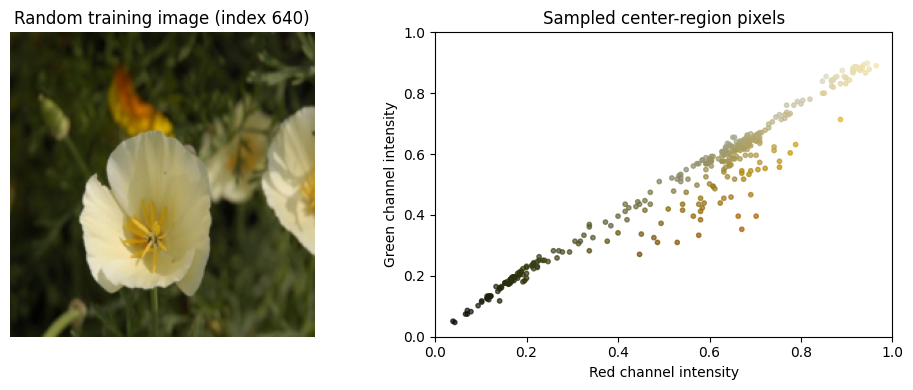

In [4]:
# Sanity check: visualize a random image and its sampled pixels side by side

import matplotlib.pyplot as plt
import numpy as np

# Pick a random image from the training set
i = np.random.randint(len(train_ds))
img, _ = train_ds[i]          # img is a tensor [3, H, W]

# Collect pixels from the center region
pixels = hue_collector(img)   # pixels is a NumPy array [N, 3] with values in [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: show the randomly selected image
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title(f"Random training image (index {i})")
axes[0].axis("off")

# Right: scatter plot of sampled RGB pixels (R vs G), colored by their RGB values
axes[1].scatter(
    pixels[:, 0],    # Red channel
    pixels[:, 1],    # Green channel
    c=pixels,        # Use RGB colors for points
    s=10,
    alpha=0.7
)

# Make the axes easier to read
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xticks(np.linspace(0, 1, 6))
axes[1].set_yticks(np.linspace(0, 1, 6))

axes[1].set_xlabel("Red channel intensity")
axes[1].set_ylabel("Green channel intensity")
axes[1].set_title("Sampled center-region pixels")

plt.tight_layout()
plt.show()

# `classify_pixel_color`

Now that we have a crop of pixels from the image to evaluate, we convert them from RGB (Red, Green, Blue intensities) to HSV (Hue, Saturation, Value).

HSV is convenient here because:
- Hue encodes the basic color (red, yellow, purple-blue, etc.) as a single angle.
- Saturation and Value help us recognize near-white pixels, where color is weak or brightness is very high.

We’ll use simple thresholds on Hue, Saturation, and Value to assign each pixel to a coarse color class.

In [5]:
import colorsys

def classify_pixel_color(r, g, b):
    """
    Classify a single pixel into a coarse color category using HSV thresholds.

    Args:
        r, g, b (float): Red, Green, Blue channel values in [0, 1].

    Returns:
        str: One of:
            "white", "red_pink", "orange", "yellow", "green", "purple_blue", or "none".
    """

    # Convert from RGB (0–1) to HSV:
    # h in [0,1) -> hue as a fraction of the color wheel
    # s in [0,1] -> saturation (color intensity)
    # v in [0,1] -> value/brightness
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    deg = h * 360 # easier to reason about degrees than fractions

    # Heuristic for "white": low saturation but still fairly bright.
    # (These thresholds are intentionally loose; we only need coarse labels.)
    if s < 0.2 and v > 0.7:
        return "white"

    # Hue-based color classification (degrees around the color wheel).
    # Red wraps around 0 degrees, so we combine low and high hue values.
    if deg < 5 or deg >= 300:
        return "red_pink"
    if 5 <= deg < 32:
        return "orange"
    if 32 <= deg < 75:
        return "yellow"
    if 75 <= deg < 165:
        return "green"
    if 165 <= deg < 300:
        return "purple_blue"

    # Fallback for any pixel that doesn't fit the thresholds above.
    return "none"

# `hue_to_color`

With pixel-level colors classified, the next step is to assign a single coarse color label to the entire image. To do this, we apply a simple heuristic based on the distribution of pixel colors in the sampled center region.

This heuristic was developed through trial and error and is intentionally lightweight. It does not need to be 
perfect, because the goal is simply to generate approximate labels that we will later use to train a CNN. 
The CNN will ultimately learn a much more flexible representation of color than this handcrafted approach.

In [6]:
from collections import Counter

def hue_to_color(pixels, sig_threshold=0.20):
    """
    Assign a single coarse color label to an image, based on the majority color
    of sampled pixels in the center region.

    Args:
        pixels (np.ndarray): Array of shape [N, 3], containing RGB values in [0, 1].
        sig_threshold (float): Minimum fraction a color class must represent
                               to be considered "significant."

    Returns:
        str: One of the coarse color classes, e.g.:
             "purple_blue", "red_pink", "white", "orange", "yellow", "green", or "none".
    """

    # Step 1: classify each sampled pixel
    classes = []
    for r, g, b in pixels:
        cls = classify_pixel_color(r, g, b)
        if cls != "none":
            classes.append(cls)

    # If no classified pixels exist (unlikely but possible), return none.
    if not classes:
        return "none"

    # Step 2: count occurrences of each color class
    counts = Counter(classes)
    total = sum(counts.values())

    # Step 3: determine which colors exceed the significance threshold
    sig_classes = [
        cls for cls, cnt in counts.items()
        if (cnt / total) > sig_threshold
    ]

    # Step 4: If exactly one significant color exists, use it directly.
    if len(sig_classes) == 1:
        return sig_classes[0]

    # Step 5 (priority resolution):
    # If multiple significant classes exist, choose according to a priority order.
    #
    # We prioritize "white" above "orange" and "yellow" because, in practice,
    # those warm colors often come from pollen in the center of otherwise white flowers.
    # Without this rule, many white flowers would be mislabeled as yellow/orange.
    priority = ["purple_blue", "red_pink", "white", "orange", "yellow"]

    for cls in priority:
        if cls in sig_classes:
            return cls

    # Step 6: fallback for edge cases
    return "green"

## Apply Labeling Heuristic

Now that we have all three components of our heuristic- `hue_collector`, `classify_pixel_color`, and `hue_to_color`- we can apply them to each image in the training set to generate coarse color labels.

Because this is a heuristic (not ground-truth annotation), the labels will not be perfect, but they will be informative enough for training a CNN that learns a more flexible representation of color. After generating the labels, we summarize how many images fall into each color category and do a spot check of label assignments.

In [7]:
from tqdm import tqdm  # progress bar

color_labels = []
imgs = []

# Loop over every training image and generate a heuristic color label
for i in tqdm(range(len(train_ds)), desc="Labeling images"):
    img, _ = train_ds[i]
    pixels = hue_collector(img)
    label = hue_to_color(pixels)

    imgs.append(img)
    color_labels.append(label)


Labeling images: 100%|█████████████████████████████████████████████████████████████| 1020/1020 [00:03<00:00, 283.48it/s]


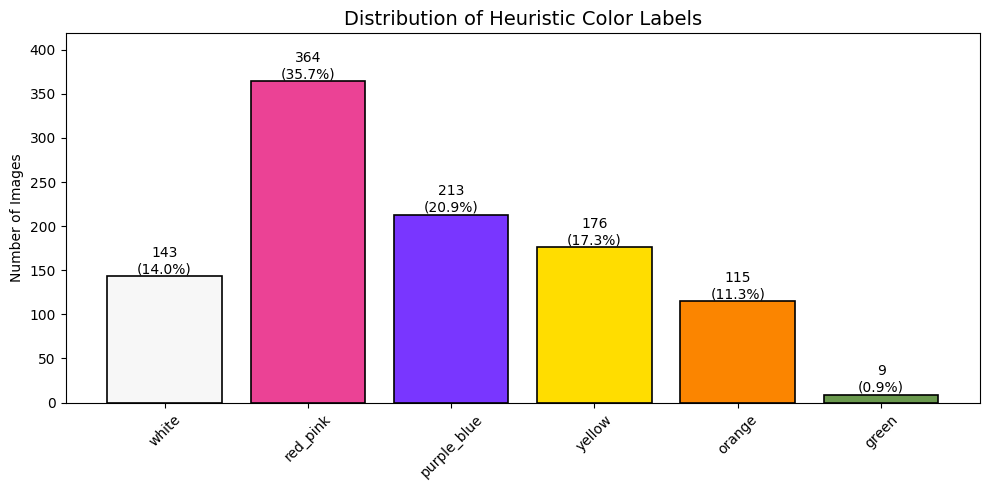

In [8]:
counts = Counter(color_labels)
classes = list(counts.keys())
values = np.array([counts[c] for c in classes])
total = values.sum()

category_colors = {
    "white":        "#f7f7f7",
    "red_pink":     "#eb4295",
    "orange":       "#fb8500",
    "yellow":       "#ffdd00",
    "green":        "#6a994e",
    "purple_blue":  "#7936ff",
}

# Map classes to their colors (fallback: gray)
bar_colors = [category_colors.get(c, "gray") for c in classes]

plt.figure(figsize=(10, 5))
bars = plt.bar(
    classes,
    values,
    color=bar_colors,
    edgecolor="black",
    linewidth=1.2
)

plt.title("Distribution of Heuristic Color Labels", fontsize=14)
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

# Add numeric labels (count + percentage) on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    percent = value / total * 100
    label = f"{value}\n({percent:.1f}%)"

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        label,
        ha='center',
        va='bottom',
        fontsize=10
    )

# Add padding so labels don't get cut off
ymax = max(values) * 1.15
plt.ylim(0, ymax)

plt.tight_layout()
plt.show()

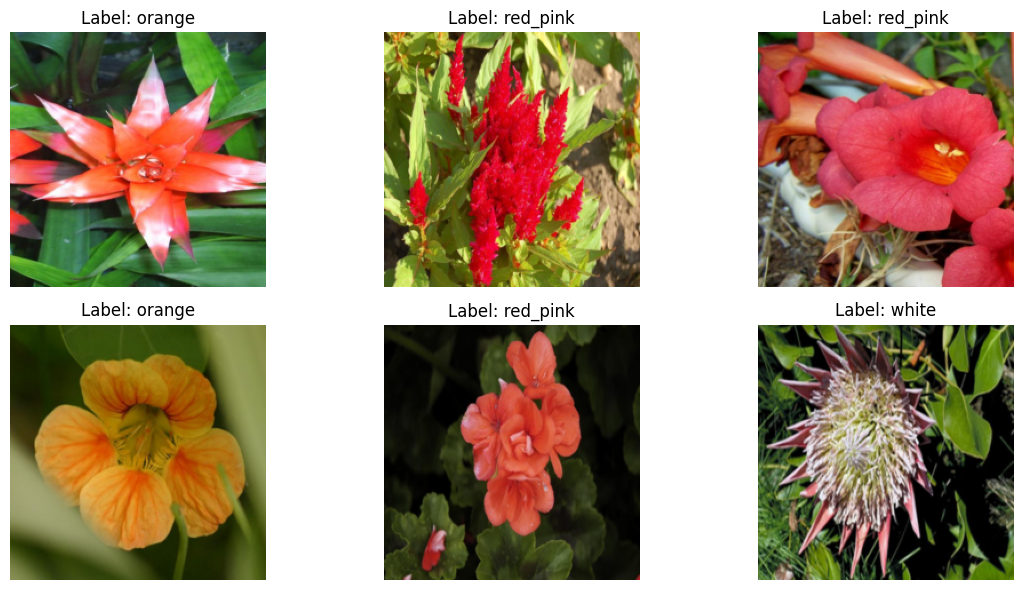

In [9]:
# Visual check of a few labeled flowers
num_examples = 6
plt.figure(figsize=(12, 6))

indices = np.random.choice(len(train_ds), num_examples, replace=False)

for i, idx in enumerate(indices):
    img = imgs[idx]
    label = color_labels[idx]
    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Result

We now have a tested, reproducible heuristic that assigns a single coarse color label to each image in the *Flowers102* dataset. This gives us a practical way to generate training labels without any manual annotation.

In the next notebook, we will apply the same labeling logic to the training, validation, and test splits, then use the labels to train a convolutional neural network (CNN) via transfer learning.